# Toxic Comment Classification

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image

import string
import re  
from nltk.corpus import stopwords
from nltk import word_tokenize
from textblob import Word


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, auc, roc_curve

import sys, os, re, csv, codecs

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

%matplotlib inline

/Users/vanessa/anaconda/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:
train.shape, test.shape

((159571, 8), (153164, 2))

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# EDA

## Check class imbalance

In [5]:
# Create a clean column
train['clean']=(train.iloc[:,2:].sum(axis=1)==0).astype(int)

/Users/vanessa/anaconda/envs/fastai/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


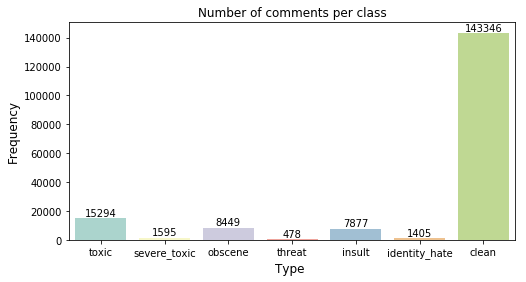

In [6]:
frequency = train.iloc[:,2:].sum()
plt.figure(figsize=(8,4))
ax= sns.barplot(frequency.index, frequency.values, palette='Set3', alpha=0.8)
plt.title("Number of comments per class")
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = frequency.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

## Multi-labeled comments

In [7]:
flags = train.iloc[:,2:].sum(axis=1).value_counts()

/Users/vanessa/anaconda/envs/fastai/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


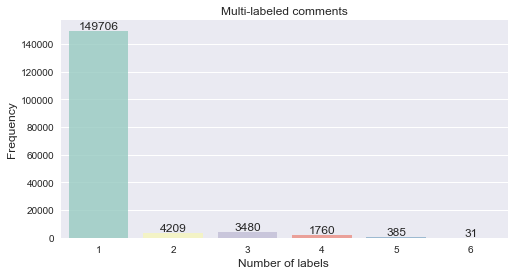

In [8]:
sns.set(style="darkgrid")
plt.figure(figsize=(8,4))
ax = sns.barplot(flags.index, flags.values, alpha=0.8,palette='Set3')
plt.title("Multi-labeled comments")
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Number of labels ', fontsize=12)

rects = ax.patches
labels = flags.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

## Word Cloud

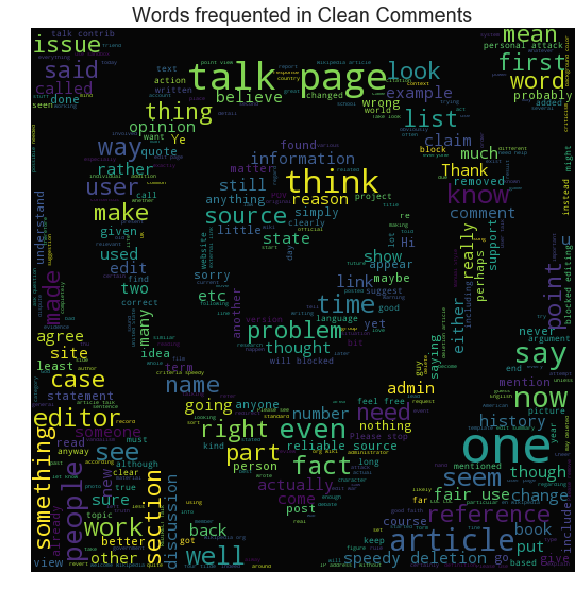

In [9]:
clean_mask=np.array(Image.open("./safe-zone.png"))
clean_mask=clean_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.savefig('clean.png')
plt.show()


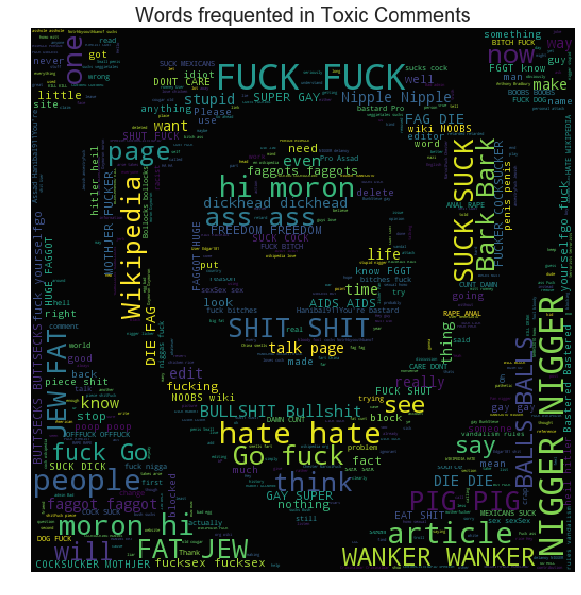

In [149]:
clean_mask=np.array(Image.open("./safe-zone.png"))
clean_mask=clean_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.savefig('toxic.png')
plt.show()

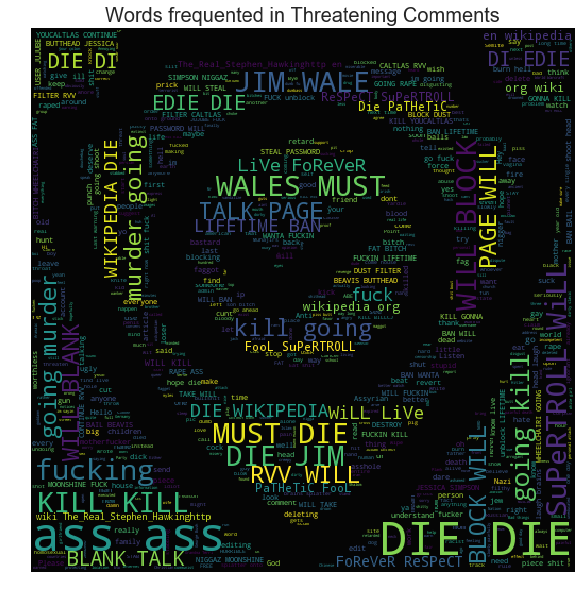

In [150]:
clean_mask=np.array(Image.open("./safe-zone.png"))
clean_mask=clean_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.savefig('threat.png')
plt.show()

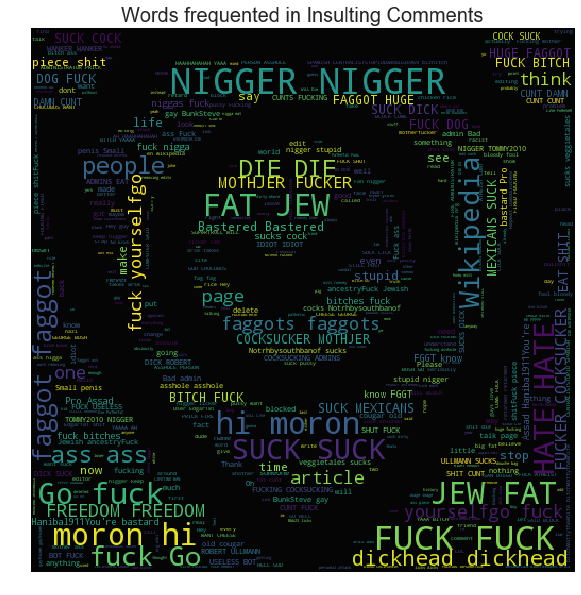

In [151]:
clean_mask=np.array(Image.open("./safe-zone.png"))
clean_mask=clean_mask[:,:,1]
#wordcloud for clean comments
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=STOPWORDS)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Insulting Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.savefig('insult.png')
plt.show()

# Feature Engineering

## Clean textual data

In [6]:
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_text = train["comment_text"].fillna("_na_")
test_text = test["comment_text"].fillna("_na_")
all_text = pd.concat([train_text, test_text])

In [7]:
def clean_text(text):
    """
    Returns list of words
    """
    text = text.lower()
    # remove \n
    text = re.sub("\\n","", text)
    # remove ip
    text = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","", text)
    #removing usernames
    text = re.sub("\[\[.*\]","",text)    
    #Split the sentences into words
    words = word_tokenize(text)
    eng_stopwords = set(stopwords.words('english'))
    words = [Word(word).lemmatize('v') for word in words]
    words = [w for w in words if not w in eng_stopwords]   
    clean_text=" ".join(words)
    return(clean_text)

In [8]:
all_clean_text = all_text.apply(lambda x :clean_text(x))
train_clean_text = train_text.apply(lambda x :clean_text(x))
test_clean_text = test_text.apply(lambda x :clean_text(x))

# N-grams + Logistic Regression

In [9]:
tfv = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 3),
    max_features=10000)
tfv.fit(all_clean_text)
train_word_features = tfv.transform(train_clean_text)
test_word_features = tfv.transform(test_clean_text)

In [10]:
scores = []
for class_ in classes:
    LR = LogisticRegression(C=0.1, solver='sag')
    cv_score = np.mean(cross_val_score(LR, train_word_features, train[class_], cv=3, scoring='accuracy'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_, cv_score))
    LR.fit(train_word_features, train[class_])
print('Total CV score is {}'.format(np.mean(scores)))

ValueError: 'neg_logloss' is not a valid scoring value. Valid options are ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']

In [ ]:
LR.predict()

# LSTM model with Keras

In [ ]:
embedding = '/Users/vanessa/data/glove/glove.6B.50d.txt'

In [ ]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

In [ ]:
# Turn each comment into a list of word indexes 
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_text.values))
tokenized_train = tokenizer.texts_to_sequences(train_text.values)
tokenized_test = tokenizer.texts_to_sequences(test_text.values)

In [ ]:
# Trim the long sentences and pad the short ones to reach equal length
X_train = pad_sequences(tokenized_train, maxlen=maxlen)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

In [ ]:
def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [ ]:
# Create embedding matrix
all_embs = np.stack(embeddings_index.values())
# Get mean and std
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

In [ ]:
# Use glove embedding's mean and std to generate random initialization for words that aren't in Glove
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)

In [ ]:
# Bidrectional LSTM with 2 fully connected layers
# Added dropout to prevent overfitting
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [51]:
model.fit(X_t, y, batch_size=32, epochs=2, validation_split=0.1);

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 38287s 267ms/step - loss: 0.0592 - acc: 0.9794 - val_loss: 0.0476 - val_acc: 0.9823
Epoch 2/2
143613/143613 [==============================] - 822s 6ms/step - loss: 0.0440 - acc: 0.9835 - val_loss: 0.0458 - val_acc: 0.9829


In [155]:
y_test = model.predict([X_te], batch_size=1024, verbose=1)

153164/153164 [==============================] - 134s 875us/step
